In [ ]:
#import libraries
import keras
from tensorflow.keras.layers import Layer
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate,\
    GlobalAveragePooling2D, AveragePooling2D, Flatten
import cv2
import numpy as np
from PIL import Image
import requests
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import math
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical
import matplotlib.pyplot as plt

#Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Since our images are stored in Google Drive, we need to change the image paths to Google Drive.

In [ ]:
#get data into dataframe
url = 'https://raw.githubusercontent.com/Shirone0110/BookCover/main/BookCover_2.csv'
df = pd.read_csv(url)
for i in range(len(df.index)):
  path = '/content/drive/MyDrive/BookCovers/image_' + str(i) + '.jpg'
  df['image'][i] = path

We choose 3 categories with few overlapping books to work on.

In [ ]:
#select categories
df = df[(df['category'] == 'Crime-Thriller') | (df['category'] == 'Food-Drink') | 
        (df['category'] == 'Graphic-Novels-Anime-Manga')]
df.head()

,image,name,author,category
7900,/content/drive/MyDrive/BookCovers/image_7900.jpg,1984,George Orwell,Crime-Thriller
7901,/content/drive/MyDrive/BookCovers/image_7901.jpg,Man's Search For Meaning,Viktor E. Frankl,Crime-Thriller
7902,/content/drive/MyDrive/BookCovers/image_7902.jpg,Animal Farm,George Orwell,Crime-Thriller
7903,/content/drive/MyDrive/BookCovers/image_7903.jpg,The Husband's Secret,Liane Moriarty,Crime-Thriller
7904,/content/drive/MyDrive/BookCovers/image_7904.jpg,Gone Girl,Gillian Flynn,Crime-Thriller


Since there are overlapping books, we drop the duplicated book names. We shuffle the data to make sure books of same category don't end up in one block.

In [ ]:
#drop duplicated entries and shuffle data
df = df.drop_duplicates(subset = 'name', keep = 'last')
df = df.sample(frac = 1)

Then we transform images into numpy array with normalized range [0, 1]

In [ ]:
#transform data into numpy array 
X = []
for url in df['image']:
  im = cv2.imread(url)                      #read image
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  #convert image into RBG
  arr = np.asarray(im)                      #convert image into numpy array
  arr = arr / 255                           #normalized into [0, 1] values
  X.append(arr)

X = np.array(X)

Then we one-hot encode the book categories.

In [ ]:
#one-hot encode the labels
encoder = LabelEncoder()
numbered_labels = encoder.fit_transform(df['category'])
Y = to_categorical(numbered_labels)

We split the data into 3 sets: train set, validation set, test set.

In [ ]:
#train test split data
x_train, x_test, y_train, y_test = train_test_split(X, Y)

#split into validation set
validation_ratio = 0.10
validation_record_num = int(np.round(len(x_train) * validation_ratio))
x_val = x_train[:validation_record_num]
y_val = y_train[:validation_record_num]
x_train = x_train[validation_record_num:]
y_train = y_train[validation_record_num:]

#Build model

The model is built based on the guide linked in References.

In [ ]:
#function for inception layer
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, 
                     filters_5x5_reduce, filters_5x5, filters_pool_proj,
                     name = None):
  conv_1x1 = Conv2D(filters_1x1, (1, 1), padding = 'same', activation = 'relu',
                    kernel_initializer = kernel_init,
                    bias_initializer = bias_init)(x)
  conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding = 'same', 
                    activation = 'relu', kernel_initializer = kernel_init,
                    bias_initializer = bias_init)(x)
  conv_3x3 = Conv2D(filters_3x3, (3, 3), padding = 'same', activation = 'relu',
                    kernel_initializer = kernel_init,
                    bias_initializer = bias_init)(conv_3x3)
  conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding = 'same', 
                    activation = 'relu', kernel_initializer = kernel_init,
                    bias_initializer = bias_init)(x)
  conv_5x5 = Conv2D(filters_5x5, (5, 5), padding = 'same', activation = 'relu',
                    kernel_initializer = kernel_init,
                    bias_initializer = bias_init)(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides = (1, 1), padding = 'same')(x)
  pool_proj = Conv2D(filters_pool_proj, (1, 1), padding = 'same', 
                     activation = 'relu', kernel_initializer = kernel_init,
                     bias_initializer = bias_init)(pool_proj)
  output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis = 3, 
                       name = name)
  return output

In [ ]:
#create GoogLeNet architecture
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value = 0.2)

input_layer = Input(shape = (200, 128, 3))

x = Conv2D(64, (7, 7), padding = 'same', strides = (2, 2), activation = 'relu',
           name = 'conv_1_7x7/2', kernel_initializer = kernel_init,
           bias_initializer = bias_init)(input_layer)
x = MaxPool2D((3, 3), padding = 'same', strides = (2, 2),
              name = 'max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding = 'same', strides = (1, 1), activation = 'relu',
           name = 'conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding = 'same', strides = (1, 1), activation = 'relu',
           name = 'conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding = 'same', strides = (2, 2), 
              name = 'max_pool_2_3x3/2')(x)

x = inception_module(x, 64, 96, 128, 16, 32, 32, name = 'inception_3a')
x = inception_module(x, 128, 128, 192, 32, 96, 64, name = 'inception_3b')
x = MaxPool2D((3, 3), padding = 'same', strides = (2, 2), 
              name = 'max_pool_3_3x3/2')(x)

x = inception_module(x, 192, 96, 208, 16, 48, 64, name = 'inception_4a')

x1 = AveragePooling2D((5, 5), strides = 3)(x)
x1 = Conv2D(128, (1, 1), padding = 'same', activation = 'relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation = 'relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(3, activation = 'softmax', name = 'auxilliary_output_1')(x1)

x = inception_module(x, 160, 112, 224, 24, 64, 64, name = 'inception_4b')
x = inception_module(x, 128, 128, 256, 24, 64, 64, name = 'inception_4c')
x = inception_module(x, 112, 144, 288, 32, 64, 64, name = 'inception_4d')

x2 = AveragePooling2D((5, 5), strides = 3)(x)
x2 = Conv2D(128, (1, 1), padding = 'same', activation = 'relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation = 'relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(3, activation = 'softmax', name = 'auxilliary_output_2')(x2)

x = inception_module(x, 256, 160, 320, 32, 128, 128, name = 'inception_4e')
x = MaxPool2D((3, 3), strides = (2, 2), padding = 'same',
              name = 'max_pool_4_3x3/2')(x)
x = inception_module(x, 256, 160, 320, 32, 128, 128, name = 'inception_5a')
x = inception_module(x, 384, 192, 384, 48, 128, 128, name = 'inception_5b')

x = GlobalAveragePooling2D(name = 'avg_pool_5_3x3/1')(x)
x = Dropout(0.4)(x)
x = Dense(3, activation = 'softmax', name = 'output')(x)

In [ ]:
#check model
model = Model(input_layer, [x, x1, x2], name = 'inception_v1')
model.summary()

In [ ]:
#define learning rate, callbacks
epochs = 100
initial_lrate = 0.01

def decay(epoch, steps = 100):
  initial_lrate = 0.01
  drop = 0.96
  epochs_drop = 32
  lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch)/ epochs_drop))
  return lrate

sgd = SGD(initial_lrate, 0.9, False)
lr_sc = LearningRateScheduler(decay, verbose = 1)

model.compile(loss = ['categorical_crossentropy', 'categorical_crossentropy',
              'categorical_crossentropy'], loss_weights = [1, 0.3, 0.3],
              optimizer = sgd, metrics = ['accuracy'])

Then we fit the model to training set.

In [ ]:
#run model
history = model.fit(x_train, [y_train, y_train, y_train], 
                    validation_data = (x_val, [y_val, y_val, y_val]), 
                    epochs = epochs, batch_size = 128, callbacks = [lr_sc])

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
15/15 [==============================] - 194s 13s/step - loss: 1.9726 - output_loss: 1.2684 - auxilliary_output_1_loss: 1.1687 - auxilliary_output_2_loss: 1.1787 - output_accuracy: 0.3419 - auxilliary_output_1_accuracy: 0.3314 - auxilliary_output_2_accuracy: 0.3273 - val_loss: 1.8257 - val_output_loss: 1.1627 - val_auxilliary_output_1_loss: 1.1068 - val_auxilliary_output_2_loss: 1.1030 - val_output_accuracy: 0.3029 - val_auxilliary_output_1_accuracy: 0.3173 - val_auxilliary_output_2_accuracy: 0.3173
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
15/15 [==============================] - 188s 13s/step - loss: 1.8131 - output_loss: 1.1497 - auxilliary_output_1_loss: 1.1020 - auxilliary_output_2_loss: 1.1093 - output_accuracy: 0.3355 - auxilliary_output_1_accuracy: 0.3621 - auxilliary_output_2_accuracy: 0.3225 - val_loss: 1.7784 - val_output_loss: 1.1213 - val_auxilliary_output_

Then evaluate the model on test set.

In [ ]:
#run on test set
model.evaluate(x_test, y_test)

22/22 [==============================] - 14s 600ms/step - loss: 1.2234 - output_loss: 0.7634 - auxilliary_output_1_loss: 0.7686 - auxilliary_output_2_loss: 0.7649 - output_accuracy: 0.6974 - auxilliary_output_1_accuracy: 0.6513 - auxilliary_output_2_accuracy: 0.6772


[1.2234407663345337,
 0.7633762955665588,
 0.768600583076477,
 0.7649474740028381,
 0.6974063515663147,
 0.651296854019165,
 0.6772334575653076]

We check to see if the model has finished training by looking at model's loss.

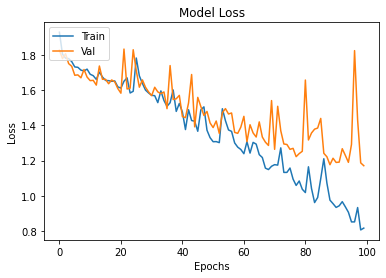

In [ ]:
#plot model loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

Observe model's accuracy.

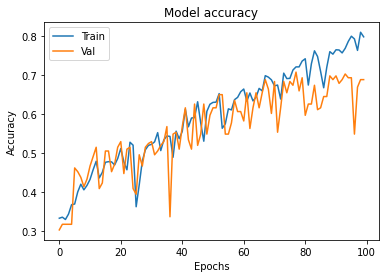

In [ ]:
#plot model accuracy
plt.plot(history.history["output_accuracy"])
plt.plot(history.history["val_output_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

Because this model trained for 5 hours, we want to make sure we don't lose it.

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


## References

https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/